In [1]:
import sys
sys.path.append('../code/functions')
sys.path.append('../../pipeline_1/code/functions')

import cv2
import glob
import random
import numpy as np
import tiffIO as io
import scipy.io as sio
import matplotlib.pyplot as plt
import connectLib as cLib
import matplotlib.lines as mlines

from qaLib import visDiff
from qaLib import precision_recall_f1
from scipy import ndimage
from cluster import Cluster
from scipy.ndimage.filters import convolve
from skimage.filters import threshold_otsu
from skimage.exposure import equalize_adapthist
from skimage.morphology import remove_small_objects
from skimage.measure import label

In [2]:
rawData = sio.loadmat('collman14/collman14v2/PSDr_p1.mat')

keys = rawData.keys()
parsedKey = None
for key in keys:
    if not '__' in key:
        parsedKey = key
        break
if not parsedKey is None:
    out = np.rollaxis(rawData[parsedKey], 2, 0)
else:
    out =  None

In [3]:
rawData = sio.loadmat('collman14/collman14v2/annotation_p1.mat')

keys = rawData.keys()
parsedKey = None
for key in keys:
    if not '__' in key:
        parsedKey = key
        break
if not parsedKey is None:
    annotations = np.rollaxis(rawData[parsedKey], 2, 0)
else:
    annotations =  None

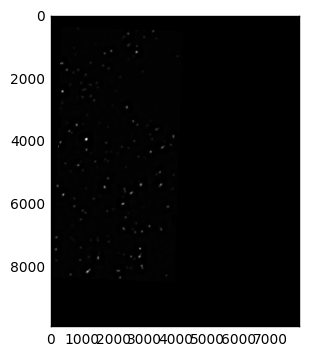

In [4]:
plt.figure()
plt.imshow(out[0], cmap='gray')
plt.show()

In [5]:
testData = out #renaming for convinience

 We found about .006 of the data, or about 100 clusters of average size ~900 voxels, to be labeled synapse in the data. In order to validate our approach, we will run a test where we randomly select 100 clusters of size ~900 voxels from the data and then compute the resulting precision and f1.
 
 Note that here, we only allow for generation from x=0 to x/2, as the data quite obviously stops there in the image

In [6]:
def visVolDiff(a, b):
    fig = plt.figure()
    plt.imshow(visDiff(a, b))
    plt.title("Disparity Between Predictions And Labels")

    blue_line = mlines.Line2D([], [], color='blue',markersize=15, label='Blue line')
    green_line = mlines.Line2D([], [], color='green', markersize=15, label='Green line')
    red_line = mlines.Line2D([], [], color='red', markersize=15, label='Green line')


    handles = [red_line, blue_line, green_line]
    labels = ["Predictions Only", "Labels Only", "Both Predictions and Labels"]
    fig.legend(handles=handles, labels=labels, loc=3)
    plt.show()

(0.06, 0.008379888268156424, 0.014705882352941175)


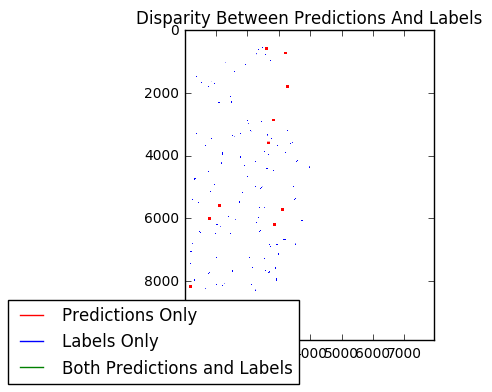

In [7]:
for i  in range(1):
    predictions = np.zeros_like(testData)
    for i in range(100):
        z = int(random.random() * predictions.shape[0])
        y = int(random.random() * predictions.shape[1])
        x = int(random.random() * predictions.shape[2]/2.)
        predictions[
            max(0, z-1):min(testData.shape[0],z+1),
            max(0, y-45):min(testData.shape[1],y+45),
            max(0, x-45):min(testData.shape[1],x+45)
        ] = 1
    lClusters = cLib.clusterThresh(annotations, 0, 10000000)
    pClusters = cLib.clusterThresh(predictions, 0, 10000000)
    print precision_recall_f1(lClusters, pClusters)
    visVolDiff(predictions[0], annotations[0])